# Assignment 3

**Assignment 3: Evolutionary Algorithms**

**Goal**: Get familiar with evolutionary algorithms by implementing it and applying it to a given non-differentiable optimization task.

In this assignment, we are going to learn about evolutionary algorithms (EAs). The goal is to implement components of an evolutionary algorithm: a recombination operator, a mutation operator, and selection mechanisms, and analyze their behavior. This assignment is open to any choice of the aforementioned components​ as long as they are well motivated.

We are interested in optimizing a given **black-box** function that could be queried (i.e., it returns a value of the objective for given input values), but the gradient wrt the input cannot be calculated. The input to the system is a vector:
$$\mathbf{x} =[\alpha_0, n, \beta, \alpha]^{\top} \in [−2,10] \times [0,10] \times [−5,20] \times [500,2500]. $$

The optimized function is based on the gene repressilator model. For details, please see Section 4.2 in <a href='https://arxiv.org/abs/2002.02869' target='_blank'>HERE</a>.

## 1. Understanding the problem

The considered problem is about finding parameter values of a model widely used in biology, namely, the gene repressilator model. This model represents a simple network in which a gene (mRNA) is produced by a protein, and then this gene is used to produce another protein. Altogether, there are 3 genes and 3 proteins that are connected as follows: $m_1 \rightarrow p_1$, $p_1 \rightarrow m_2$, $m_2 \rightarrow p_2$, $p_2 \rightarrow m_3$, $m_3 \rightarrow p_3$, $p_3 \rightarrow m_1$.

Please run the code below and spend a while on analyzing the signals in the model. Think of the osscilatory character of the signals.

If any code line is unclear to you, please read on that in numpy or matplotlib docs.

In [1]:
import copy
import pickle

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

EPS = 1.0e-7

In [2]:
# PLEASE DO NOT REMOVE!
# This is the main class for the gene repressilator model.
# There is no need to understand how it works! You can treat it as a black-box.
# It is important to realize that we can always ask this object to give us
# an evaluation of given parameter values.
class Repressilator(object):
    def __init__(self, y_real, params):
        super().__init__()
        self.y_real = y_real.copy()
        self.params = params.copy()

    # The definition of the gene repressilator model as a system of ODEs.
    def repressilator_model(self, t, y):
        m1, m2, m3, p1, p2, p3 = y[0], y[1], y[2], y[3], y[4], y[5]

        alpha0 = self.params["alpha0"]
        n = self.params["n"]
        beta = self.params["beta"]
        alpha = self.params["alpha"]

        dm1_dt = -m1 + alpha / (1.0 + p3**n) + alpha0
        dp1_dt = -beta * (p1 - m1)
        dm2_dt = -m2 + alpha / (1.0 + p1**n) + alpha0
        dp2_dt = -beta * (p2 - m2)
        dm3_dt = -m3 + alpha / (1.0 + p2**n) + alpha0
        dp3_dt = -beta * (p3 - m3)

        return dm1_dt, dm2_dt, dm3_dt, dp1_dt, dp2_dt, dp3_dt

    # A numerial solver for the model (here we use Runge-Kutta 4.5)
    def solve_repressilator(self):
        # we need to use lambda function if we want to pass some parameters
        solution = solve_ivp(
            lambda t, y: self.repressilator_model(t, y),
            t_span=(self.params["t0"], self.params["t1"]),
            y0=self.params["y0"],
            method="RK45",
            t_eval=self.params["t_points"],
        )
        y_points = np.asarray(solution.y)
        return self.params["t_points"], y_points

    # An auxiliary function: setting parameters.
    def set_params(self, x):
        self.params["alpha0"] = x[0]
        self.params["n"] = x[1]
        self.params["beta"] = x[2]
        self.params["alpha"] = x[3]

    # Calculating the objective function.
    # Here, we use the Euclidean distance between the real data and the synthetic data.
    @staticmethod
    def loss(y_real, y_model):
        # we assume only m's are observed!
        y_r = y_real[0:3]
        y_m = y_model[0:3]
        if y_r.shape[1] == y_m.shape[1]:
            return np.mean(np.sqrt(np.sum((y_r - y_m) ** 2, 0)))
        else:
            return np.infty

    def objective(self, x):
        if len(x.shape) > 1:
            objective_values = []
            for i in range(x.shape[0]):
                xi = x[i]
                self.set_params(xi)

                _, y_model = self.solve_repressilator()
                objective_values.append(self.loss(self.y_real, y_model))

            objective_values = np.asarray(objective_values)
        else:
            self.set_params(x)

            _, y_model = self.solve_repressilator()
            objective_values = self.loss(self.y_real, y_model)

        return objective_values

In [3]:
# PLEASE DO NOT REMOVE!
# Initialize the problem.
# Here we set the real parameters and generate "real" data. To make the problem
# more realistic, we add a small Gaussian noise.
params = {}
params["alpha0"] = 1.1
params["n"] = 2.9
params["beta"] = 5.5
params["alpha"] = 500
params["t0"] = 0.0
params["t1"] = 60.5
params["t_points"] = np.arange(0, 60, 0.5)
params["x0"] = np.asarray([[5.64167522, 2.07180539, 3.56690274, 7.0015145]])
params["y0"] = np.asarray([0.0, 0.0, 0.0, 2.0, 1.0, 3.0])

# Generate "real" data
r = Repressilator([0], params)
_, y_real = r.solve_repressilator()
del r  # we remove the object, just in case
y_real = y_real + np.random.randn(*y_real.shape) * 5.0  # add noise!

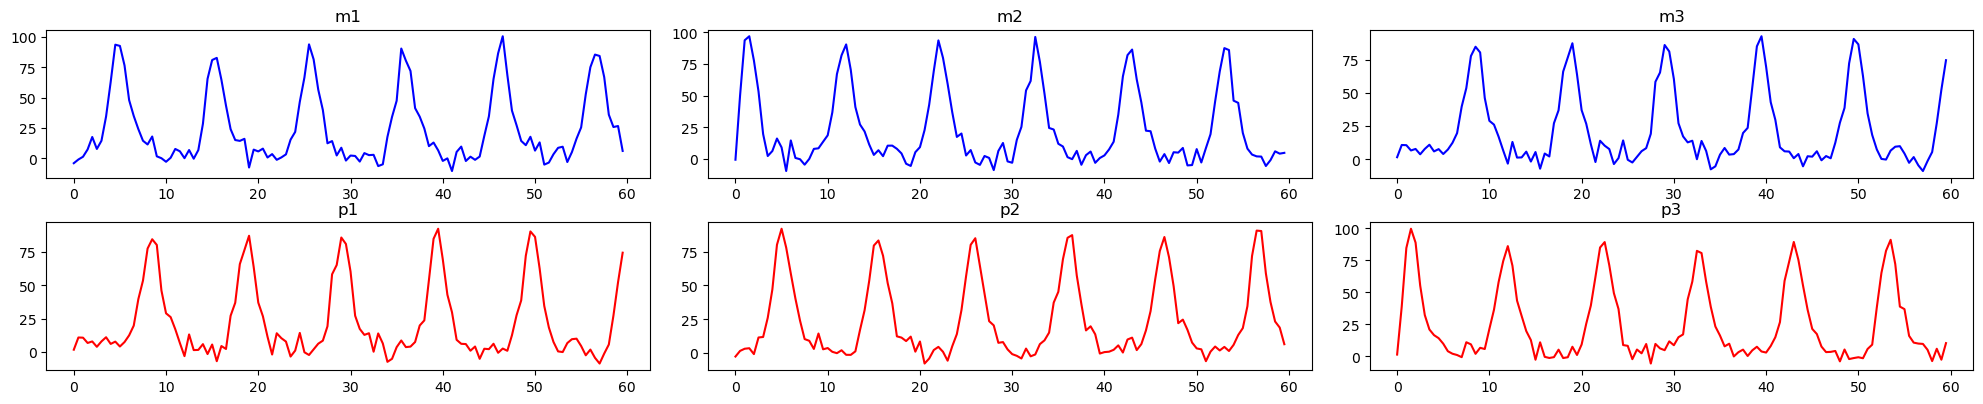

In [4]:
# PLEASE DO NOT REMOVE
# Here, we plot all signals in the model.
# Note that later on, we assume that only gene expression (i.e., m1, m2, m3)
# are observed (blue plots) and proteins (i.e. p1, p2, p3) are unobserved (in red).
t = params["t_points"]

fig_data, axs = plt.subplots(2, 3, figsize=(20, 4))
fig_data.tight_layout()

for i in range(2):
    for j in range(3):
        if i == 0:
            title = "m"
            color = "b"
        else:
            title = "p"
            color = "r"

        axs[i, j].plot(t, y_real[2 * i + j], color)
        axs[i, j].set_title(title + str(j + 1))

## 2. Evolutionary Algorithms

In this assignment, you are asked to implement an evolutionary algorithm (EA). Please take a look at the class below and fill in the missing parts. Please keep in mind that you are free to choose any operations as lons as they are appropriate for evolutionary algorithms.

NOTE: Please pay attention to the inputs and outputs of each function.

**Question 1 (0-0.5pt):** Do you use a mutation operator? If yes, please explain in detail your choice. If not, please explain why not.

**Answer:**
Yes. For each component, we mutate it by adding gaussian noise with 1/pop_size% probability. And some of the cases, we mutate it to a uniform sample. We chose this because it is easy to implement and it created better results. The way we add gaussian means that samples can get stuck around bounds, and sometimes a uniform value might help that. 

**Question 2 (0-0.5pt):** Do you use a cross-over operator? If yes, please explain in detail your choice. If not, please explain why not.

**Answer:**
Yes. We used arithmetic recombination for simplicity. If a crossover occurs, we take average between two genes. If it does not occur, then we get one of the parents' genes. Crossover occurs with 75% probability.

**Question 3 (0-0.5pt):** What kind of selection mechanism do you use? Please explain in detail and motivation your choice.

**Answer:**
We use roulette wheel selection because it is easy to implement and it creates better results. We use exp(-f(x)) for values given in the fitness array, because some specimen have infinite fitness, but most of them are around 20-100. So we normalise it by using exp(-f(x)/70), we divide by 70 because then f_sum values are more easy to understand and use. Then for each parent, we choose another parent with the roulette wheel selection and then return the pairs.

**Question 4 (0-0.5pt):** Do you use any other operation? If yes, please explain and motivate your choice.

**Answer:**
We use survivor selection. We order the population based on fitness then select the best pop_size ones. This is (mu + lambda) selection, chose it because it was simple and worked fine.

**Question 5 (0-0.5-1pt):** Please provide a pseudo-code for your evolutionary algorithm. Please try to be as formal as possible!

**Answer:**
Init population and their fitness.

For each element in the population, select a mate based on the roulette wheel. Return the pairs.

For each genes of pairs, return a new gene crossed over or selected randomly. Construct children with these genes.

Mutate children's genes by adding gaussian noise.

Calculate fitness of children.

Select the best pop_size of the population. 

Repeat back to line 2 num_generations times.

Stop


In [5]:
# =========
# GRADING:
# 0
# 0.5 pt if code works but some functions are incorrect and it is badly explained
# 1.0 pt if code works but some functions are incorrect
# 2.0 pt if code works but it does not correspond to the description above and it is badly explained
# 2.5 pt if code works and it is well explained, but it does not correspond to the description above
# 3.0 pt if code works and it is aligned with the description about, but it is badly explained
# 3.5 pt if code works and it is aligned with the description about, and it is well explained
# 4.0 pt if code works, it is as it was described, it is well explained, and the proposed operations are beyond the lecture!
# =========
# Implement the Evolutionary Algorithm (EA) algorithm.
# It is equivalent to implementing the step function.
class EA(object):
    def __init__(self, repressilator, pop_size, bounds_min=None, bounds_max=None):
        self.repressilator = repressilator
        self.pop_size = pop_size
        self.bounds_min = bounds_min
        self.bounds_max = bounds_max
        # -------
        # PLEASE FILL IN
        # all necessary hyperparameters come here
        # -------

    # -------
    # PLEASE FILL IN
    # all necessary operations (e.g., mutation, selection) must come here.
    # -------
    def transformf(self, f_value):
        return np.exp(-1*f_value/70)
    
    def parent_selection(self, x_old, f_old):
        # do something
        x_parents = []
        f_parents = []

        
        f_sum = 0
        for i in range(len(x_old)):
            f_sum = f_sum + self.transformf(f_old[i])
        
        #generate a mate for each parent according to the roulette wheel.
        for x_index in range(len(x_old)):
            selection_threshold = np.random.randint(0,f_sum)

            #add fitnesses until you reach the random number
            #this selects elements by probability corresponding to
            #their fitness
            current_sum = 0
            i = 0
            while( current_sum < selection_threshold):
                current_sum = current_sum + self.transformf(f_old[i])
                i = i + 1
            
            #add the pairs to the list
            if( i == len(x_old)):
                i = len(x_old)-1
                
            x_parents.append([x_old[x_index],x_old[i]])
            f_parents.append([f_old[x_index],f_old[i]])

        
        return x_parents, f_parents
    
    def bounds_test(self, val, index):
        if( val > self.bounds_max[index] or val < self.bounds_min[index] ):
            return False
        return True
           
    def recombination(self, x_parents, f_parents):
        # do something

        x_children = []
        
        for i in range(len(x_parents)):
            p1 = x_parents[i][0]
            p2 = x_parents[i][1]
            
           
            child = []
            for component_index in range(len(p1)):
                
                passed_on_value = 0
                
                #get gene from parents
                if(np.random.random() > 0.5):
                    passed_on_value = p1[component_index]
                else:
                    passed_on_value = p2[component_index]

                #get average of parents with 75% chance. If this doesn't happen,
                #then one of the parents are used.
                if(np.random.random() > 0.25):
                    passed_on_value = (p1[component_index] + 2*p2[component_index]) / 3

                child.append(passed_on_value)
            
            x_children.append(child)

        return x_children

    def mutation(self, x_children):
        # do something
        
        for child in x_children:
            for attribute_index in range(len(child)):
                
                if (np.random.rand() > 1/self.pop_size):
                    continue
                
                #child[attribute_index] = np.random.uniform(self.bounds_min[attribute_index],self.bounds_max[attribute_index])
                val = child[attribute_index]
                
                #diameter is the distance to the closest bound
                #generate noise so that we are still within bounds 95% of the time
                dia = min(val - self.bounds_min[attribute_index], self.bounds_max[attribute_index] - val)
                noise = np.random.normal(loc = 0, scale = dia/3)
                
                #if for some reason we are out of bounds, then get a uniform value. 
                if( not self.bounds_test(val+noise, attribute_index) ):
                    child[attribute_index] = np.random.uniform(self.bounds_min[attribute_index],self.bounds_max[attribute_index])
                    continue
                    
                child[attribute_index] = val + noise
                

        return np.array(x_children)

    def survivor_selection(self, x_old, x_children, f_old, f_children):
        # do something
        x = np.concatenate([x_old, x_children])
        f = np.concatenate([f_old, f_children])
        
        #sorts f and x with respect to f.
        f, x = zip(*sorted(list(zip(f,x)), key=lambda x: x[0]))
        
        f = list(f)
        x = list(x)
        
        f = f[:self.pop_size]
        x = x[:self.pop_size]
        
        return np.array(x), np.array(f)

    # Evaluation step: DO NOT REMOVE!
    def evaluate(self, x):
        return self.repressilator.objective(x)

    def step(self, x_old, f_old):
        # -------
        # PLEASE FILL IN
        # NOTE: This function must return x, f
        # where x - population
        #       f - fitness values of the population
        # -------

        x_parents, f_parents = self.parent_selection(x_old, f_old)

        x_children = self.recombination(x_parents, f_parents)

        x_children = self.mutation(x_children)

        f_children = self.evaluate(x_children)
        
        x, f = self.survivor_selection(x_old, x_children, f_old, f_children)

        return x, f

**NOTE 1**

Since this assignment allows you implementing your own operations, this is difficult to prepare a code for that. Therefore, please use the code below to find the best set of your hyperparameters in a separate file, and then present your analysis for the best valyes of the hyperparameters here.

**NOTE 2**

Additionally, please do try various population sizes (25, 50, 100, ...). You will be asked about it later.

In [6]:
# PLEASE DO NOT REMOVE!
num_generations = 50  # if necessary, please increase the number of generations
pop_size = 100
bounds_min = [-2.0, 0.0, -5.0, 0.0]
bounds_max = [10.0, 10.0, 20.0, 2500.0]
# -------
# PLEASE FILL IN!
# Your hyperparams go here.
# PLEASE USE THE VALUES OF THE HYPERPARAMETERS FOR WHICH YOU OBTAINED THE BEST RESULTS.
# DO NOT ITERATE OVER THEM!
# -------

# Initialize the repressilator
repressilator = Repressilator(y_real, params)

# -------
# PLEASE FILL IN!
# Your object goes here:
ea = EA(repressilator, pop_size, bounds_min, bounds_max)
# -------

# Init the population
x = np.random.uniform(low=bounds_min, high=bounds_max, size=(pop_size, 4))
f = ea.evaluate(x)

# We want to gather populations and values of the best candidates to further
# analyze the algorithm.
populations = []
populations.append(x)
f_best = [f.min()]

# Run the EA.
for i in range(num_generations):
    if i % int(num_generations * 0.1) == 0:
        print("Generation: {}, best fitness: {:.2f}".format(i, f.min()))
    x, f = ea.step(x, f)
    populations.append(x)
    if f.min() < f_best[-1]:
        f_best.append(f.min())
    else:
        f_best.append(f_best[-1])
print("FINISHED!")

/tmp/ipykernel_47061/2419548718.py:23: RuntimeWarning: invalid value encountered in double_scalars
  dm2_dt = -m2 + alpha / (1.0 + p1**n) + alpha0
/tmp/ipykernel_47061/2419548718.py:21: RuntimeWarning: invalid value encountered in double_scalars
  dm1_dt = -m1 + alpha / (1.0 + p3**n) + alpha0
/tmp/ipykernel_47061/2419548718.py:25: RuntimeWarning: invalid value encountered in double_scalars
  dm3_dt = -m3 + alpha / (1.0 + p2**n) + alpha0


Generation: 0, best fitness: 45.39
Generation: 5, best fitness: 43.84
Generation: 10, best fitness: 43.84
Generation: 15, best fitness: 37.84
Generation: 20, best fitness: 37.84
Generation: 25, best fitness: 37.43
Generation: 30, best fitness: 33.53
Generation: 35, best fitness: 32.46
Generation: 40, best fitness: 24.13
Generation: 45, best fitness: 18.83
FINISHED!


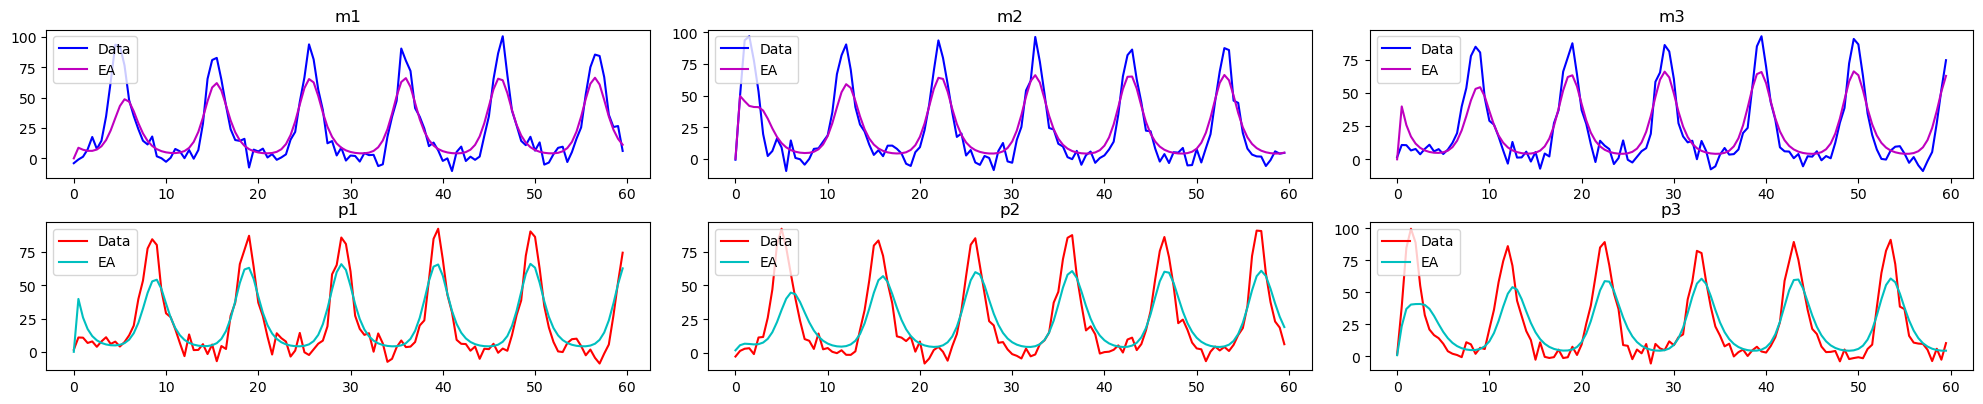

In [7]:
# PLEASE DO NOT REMOVE
# Generate signals for the best performing parameter values
repressilator.set_params(
    x[f.argmin()],
)
t, y_best = repressilator.solve_repressilator()

# Create plots
fig_ea, axs = plt.subplots(2, 3, figsize=(20, 4))
fig_ea.tight_layout()

for i in range(2):
    for j in range(3):
        if i == 0:
            title = "m"
            color = "b"
            color_m = "m"
        else:
            title = "p"
            color = "r"
            color_m = "c"

        axs[i, j].plot(t, y_real[2 * i + j], color, label="Data")
        axs[i, j].plot(t, y_best[2 * i + j], color_m, label="EA")
        axs[i, j].set_title(title + str(j + 1))
        axs[i, j].legend()

Text(0.5, 1.0, '$n$ vs. $\\beta$')

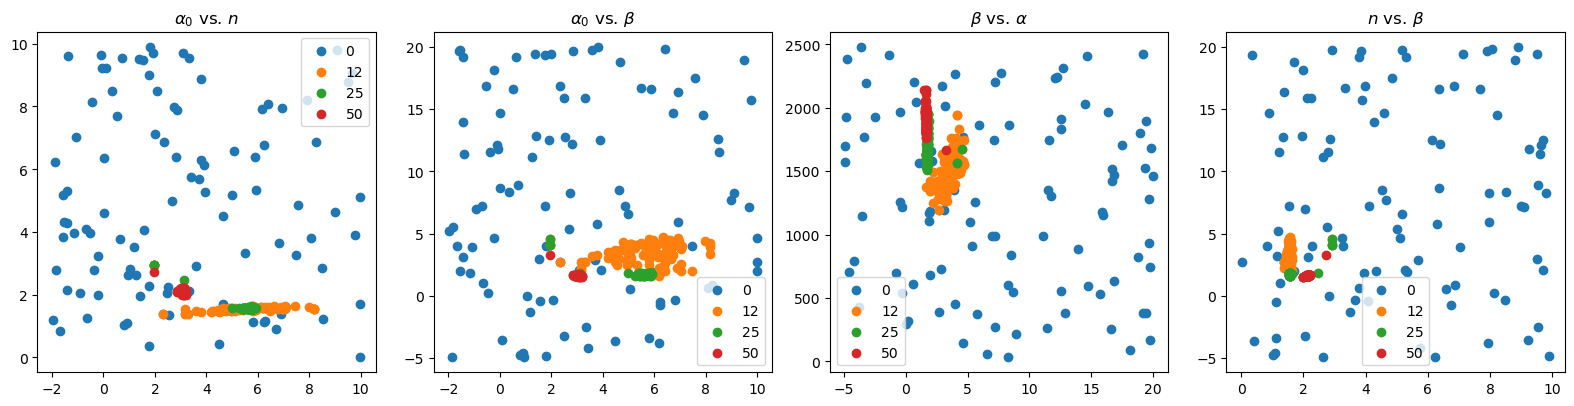

In [8]:
# PLEASE DO NOT REMOVE
# Generate scatterplots for the populations
gens = [0, num_generations // 4, num_generations // 2, num_generations]
fig_ea_pops, axs = plt.subplots(1, 4, figsize=(16, 4))
fig_ea_pops.tight_layout()


for i in range(len(gens)):
    pop_i = populations[gens[i]]
    axs[0].scatter(pop_i[:, 0], pop_i[:, 1], label=str(gens[i]))
    axs[1].scatter(pop_i[:, 0], pop_i[:, 2], label=str(gens[i]))
    axs[2].scatter(pop_i[:, 2], pop_i[:, 3], label=str(gens[i]))
    axs[3].scatter(pop_i[:, 1], pop_i[:, 2], label=str(gens[i]))
axs[0].legend(), axs[1].legend(), axs[2].legend(), axs[3].legend()
axs[0].set_title(r"$\alpha_0$ vs. $n$")
axs[1].set_title(r"$\alpha_0$ vs. $\beta$")
axs[2].set_title(r"$\beta$ vs. $\alpha$")
axs[3].set_title(r"$n$ vs. $\beta$")

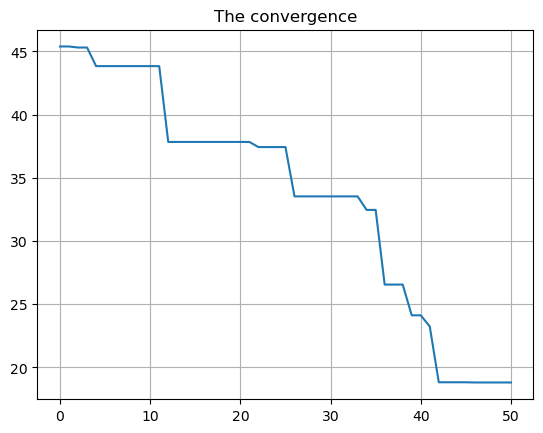

In [9]:
# PLEASE DO NOT REMOVE
# The convergence plot: the best value of the fitness function for each generation
plt.plot(range(len(f_best)), f_best)
plt.title("The convergence")
plt.grid()